# Building Models in PyMC3

## Objectives and takeaways for notebook 2

1. Introduce building blocks of Bayesian models (random variables, factor potentials) in PyMC3.
2. This is where some of the modelling flexibility that stems from the Bayesian approach should become clear.
3. Factor potentials are demonstrated in the context of structured prediction: detecting 'faces' from features that need to be in correct configuration.
4. As a second example, a simple name tagging model is built to also demonstrate factor potentials.

## Introduction

As noted in the previous notebooks, Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC3 provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials.

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

## The FreeRV class

A stochastic variable is represented in PyMC3 by a `FreeRV` class. This structure adds functionality to Theano's `TensorVariable` class, by mixing in the PyMC `Factor` class. A `Factor` is used whenever a variable contributes a log-probability term to a model. Hence, you know a variable is a subclass of `Factor` whenever it has a `logp` method, as we saw in the previous section.

A `FreeRV` object has several important attributes:

`dshape`
:   The variable's shape.

`dsize`
:   The overall size of the variable.

`distribution`
:   The probability density or mass function that describes the distribution of the variable's values.

`logp`
:   The log-probability of the variable's current value given the values
    of its parents.

`init_value`
:   The initial value of the variable, used by many algorithms as a starting point for model fitting.

`model`
:   The PyMC model to which the variable belongs.


### Creation of stochastic random variables

There are two ways to create stochastic random variables (`FreeRV` objects), which we will call the **automatic**, and **manual** interfaces.

#### Automatic

Stochastic random variables with standard distributions provided by PyMC3 can be created in a single line using special subclasses of the `Distribution` class. For example, as we have seen, the uniformly-distributed discrete variable $switchpoint$ in the coal mining disasters model (notebook 1b) is created using the automatic interface as follows:

In [1]:
import pymc3 as pm

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110)

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Similarly, the rate parameters can automatically be given exponential priors:

In [2]:
with disaster_model:
    early_mean = pm.Exponential('early_mean', lam=1)
    late_mean = pm.Exponential('late_mean', lam=1)

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. Continuous variables are represented by a specialized subclass of `Distribution` called `Continuous` and discrete variables by the `Discrete` subclass.

The main differences between these two subclasses are in the `dtype` attribute (`int64` for `Discrete` and `float64` for `Continuous`) and the `defaults` attribute, which determines which summary statistic to use for initial values when one is not specified ('mode' for `Discrete` and 'median', 'mean', and 'mode' for `Continuous`).

In [3]:
switchpoint.distribution.defaults

('mode',)

As we previewed in the introduction, `Distribution` has a class method `dist` that returns a probability distribution of that type, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. This class method allows that.

In [4]:
my_exp = pm.Exponential.dist(1)

And the following method call draws 10 samples from the Exponential distribution with $\lambda=1$.

In [5]:
my_exp.random(size=10)

array([0.45345591, 0.07434719, 0.9009084 , 4.42248748, 0.12401627,
       0.16125217, 2.2340038 , 0.09272216, 0.69310464, 0.34752503])

#### Manual

The uniformly-distributed discrete stochastic variable `switchpoint` in the disasters model could alternatively be created from a function that computes its log-probability as follows:

In [6]:
import theano.tensor as tt

In [7]:
import numpy as np
from pymc3.math import switch, log

with pm.Model():  

    
    def uniform_logp(value, lower=0, upper=111):
        """The switchpoint for the rate of disaster occurrence."""
        return switch((value > upper) | (value < lower), -np.inf, -log(upper - lower + 1))

    switchpoint = pm.DensityDist('switchpoint', logp=uniform_logp, dtype='int64')

In [8]:
switchpoint.logp({'switchpoint':4})

array(-4.7184987, dtype=float32)

In [9]:
switchpoint.logp({'switchpoint': 44})

array(-4.7184987, dtype=float32)

In [10]:
switchpoint.logp({'switchpoint':-1})

array(-inf, dtype=float32)

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Theano operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. Also, we passed the value to be evaluated by the `logp` function as a **dictionary**, rather than as a plain integer. By convention, values in PyMC3 are passed around as a data structure called a `Point`. Points in parameter space are represented by dictionaries with parameter names as they keys and the value of the parameters as the values.

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

### Specifying Custom Distributions

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC allows for the creation of user-defined functions for an **arbitrary probability distribution**. For simple statistical distributions, the `DensityDist` function takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. 


Here is a simple example inspired by a blog post by Jake Vanderplas (Vanderplas, 2014), where Jeffreys priors are used to specify priors that are invariant to transformation. In the case of simple linear regression, these are:

$$\beta \propto (1+\beta^2)^{3/2}$$

$$\sigma \propto \frac{1}{\alpha}$$

The logarithms of these functions can be specified as the argument to DensityDist and inserted into the model.

```python
import theano.tensor as T
from pymc3 import DensityDist, Uniform

with Model() as model:
    alpha = Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)
    
    # Create likelihood
    like = Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)
```

## The ObservedRV Class

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

Otherwise, observed stochastic random variables are created via the same interfaces as unobserved: **automatic** or **manual**. As an example of an automatic instantiation, consider a Poisson data likelihood :

In [11]:
with disaster_model:
    
    disasters = pm.Poisson('disasters', mu=3, observed=[3,4,1,2,0,2,2])

Here is an example of manual instantiation using the `DensityDist` class for an exponential survival likelihood:

```python
def logp(failure, value):
    return (failure * log(lam) - lam * value).sum()

x = DensityDist('x', logp, observed={'failure':failure, 'value':t})
```

Notice in this example that there are two vectors observed data for the likelihood `x`, passed as a dictionary.

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. For example, in our disasters model, `rate` is a deterministic variable.

In [12]:
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))

so `rate`'s value can be computed exactly from the values of its parents `early_mean`, `late_mean` and `switchpoint`.

There are two types of deterministic variables in PyMC3

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly. For example, the simplest way to specify the `rate` variable above is as follows:

In [13]:
with disaster_model:
    
    rate = switch(switchpoint >= np.arange(112), early_mean, late_mean)

Or, let's say we wanted to use the mean of the `early_mean` and `late_mean` variables somehere in our model:

In [14]:
with disaster_model:
    
    diff_means = pm.Deterministic('diff_means', early_mean - late_mean)

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Theano) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every MCMC iteration of are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.


```python
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))
```

In [15]:
disaster_model.named_vars

{'diff_means': diff_means,
 'disasters': disasters,
 'early_mean': early_mean,
 'early_mean_log__': early_mean_log__,
 'late_mean': late_mean,
 'late_mean_log__': late_mean_log__,
 'rate': rate,
 'switchpoint': switchpoint}

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. For example, suppose we want to constrain the difference between the early and late means in the disaster model to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

In [16]:
with disaster_model:
    
    rate_constraint = pm.Potential('rate_constraint', switch(pm.math.abs_(early_mean-late_mean)>1, -np.inf, 0))

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

Note that in the future, factor potentials will be key in studying undirected *probabilistic graphical models* (e.g. Conditional Random Fields), which can in some cases be built from *factor graphs* (= products of factor potentials).  Thus getting familiar with the concept will also help us in the future.

## Exercise 1

We will write a detector of faces from facial features: eyes, nose and mouth.  One of the ways this can be done is to have a classifier for each feature and if a candidate set is identified, ensure that the features are in a configuration that is compatible with a face.

While each facial feature will be identified via a standard approach, where it's potential position $(x,y)$ predicts the values of the pixels inside the feature region (for eye, 4x4 pixels, for mouth 1x7 pixels, etc.), the correct configuration constraints are enforced via potentials.

In [17]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

### Data
We build two 'faces' and one 'non-face', the first face is the prototype symmetric face while the second face is slightly rotated clockwise.  The non-face has the requisite features but in wrong locations.  All matrices are on a grid of 9x9 pixels.

In [18]:
face = np.vstack([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])

face.shape

(9, 9)

In [19]:
face2 = np.vstack([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])

face2.shape

(9, 9)

In [77]:
not_face = np.vstack([
    [0, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])

not_face.shape

(9, 9)

### Feature detectors
Primitive templates for eyes, nose and mouth follow.  Each value corresponds to the probability of a pixel being switched on (=1) under the assumption that the top left pixel is the start of the feature.

In [78]:
# our fixed "convolutional filters"

eye_mask = np.array([
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.9, 0.9, 0.1],
    [0.1, 0.9, 0.9, 0.1],
    [0.1, 0.1, 0.1, 0.1]])

nose_mask = np.array([
    [0.1, 0.9, 0.1],
    [0.9, 0.9, 0.9]])

mouth_mask = np.array([
    [0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1]
])

### The model
The full model is written below.  Note that we sample pixel indices from the set of possible top-left pixes of each feature.  For the face, this is $6 \times 6$, since the template itself is $4\times 4$.  We then compute $(x,y)$ coordinates from the index and use those to match the template to the processed image pixel by pixel.

The model outputs the feature positions as indices and also the negative sum of all the potentials (if active), which we call the tension.  The same function is supplied later so solutions can be tested manually if desired.  The tension should be low for actual faces that conform to model expectation and high for non-faces.

The model below is set up to process the uncommented dataset each of the datasets.

1. Study the mode structure.
2. Run the model for the face dataset.  Observe the posterior marginals.
3. Uncomment the potentials at the end of the model. Rerun for face.  What is the difference? What happened?
4. Look at the MCMC trace from this run.
5. Repeat points 2-4 for face 2.
6. Repeat points 2-4 for the non-face example.
7. There is a function supplied below `compute_tension`, which will compute the stress with respect to desired configuration of the identified solution. The function accepts the output of the model directly (indices).  For face and face2 the tension should be low, since the features are identified in the right configuration.  For the non-face, the tension should be higher.

In [79]:
## Select data set

#image_pixels = theano.shared(face)
#image_pixels = theano.shared(face2)
image_pixels = theano.shared(not_face)

# factor potentials initially switched off
use_potentials = True


with pm.Model() as face_detector:
    

    ## Facial feature detections
    
    # categorical because: https://discourse.pymc.io/t/issue-with-discreteuniform-distribution/800
    eye1_ndx = pm.Categorical('eye1_ndx', p=np.ones(36)/36)
    eye1_y = eye1_ndx//6
    eye1_x = eye1_ndx%6
    
    for idx in np.ndindex(eye_mask.shape):
        pm.Bernoulli('eye1_pixel_%d_%d' % (idx[0],idx[1]), 
                     p=eye_mask[idx], 
                     observed=image_pixels[eye1_y+idx[0],eye1_x+idx[1]])
        
    eye2_ndx = pm.Categorical('eye2_ndx', p=np.ones(36)/36)
    eye2_y = eye2_ndx//6
    eye2_x = eye2_ndx%6

    for idx in np.ndindex(eye_mask.shape):
        pm.Bernoulli('eye2_pixel_%d_%d' % (idx[0],idx[1]),
                     p=eye_mask[idx],
                     observed=image_pixels[eye2_y+idx[0],eye2_x+idx[1]])
        
    nose_ndx = pm.Categorical('nose_ndx', p=np.ones(42)/42)
    nose_y = nose_ndx//7
    nose_x = nose_ndx%6
    for idx in np.ndindex(nose_mask.shape):
        pm.Bernoulli('nose_pixel_%d_%d' % (idx[0],idx[1]),
                     p=nose_mask[idx],
                     observed=image_pixels[nose_y+idx[0],nose_x+idx[1]])

    mouth_ndx = pm.Categorical('mouth_ndx', p=np.ones(9)/9)
    mouth_y = mouth_ndx
    mouth_x = 0
    for idx in np.ndindex(mouth_mask.shape):
        pm.Bernoulli('mouth_pixel_%d_%d' % (idx[0],idx[1]),
                     p=mouth_mask[idx],
                     observed=image_pixels[mouth_y+idx[0],mouth_x+idx[1]])
    
    ## Potentials
    
    # distance between eyes should be 5, anything else is penalized
    # eye1 to nose distance should be 5
    # eye2 to nose distance should be 5
    # mouth is third row down from nose

    if use_potentials:
        p1 = pm.Potential('eye_dist', -0.5*pm.math.abs_((eye2_x-eye1_x)**2 + (eye1_y-eye2_y)**2 - 25))
        p2 = pm.Potential('nose_eye1', -0.5*pm.math.abs_((nose_x-eye1_x)**2 + (nose_y-eye1_y)**2 - 25))
        p3 = pm.Potential('nose_eye2', -0.5*pm.math.abs_((nose_x-eye2_x)**2 + (nose_y-eye2_y)**2 - 25))
        p4 = pm.Potential('mouth_nose', -0.5*pm.math.abs_((mouth_y-nose_y-3)**2))
        tension = pm.Deterministic('tension', -(p1+p2+p3+p4))

Assigned CategoricalGibbsMetropolis to eye1_ndx
Assigned CategoricalGibbsMetropolis to eye2_ndx
Assigned CategoricalGibbsMetropolis to nose_ndx
Assigned CategoricalGibbsMetropolis to mouth_ndx
100%|██████████| 6000/6000 [00:05<00:00, 1131.06it/s]


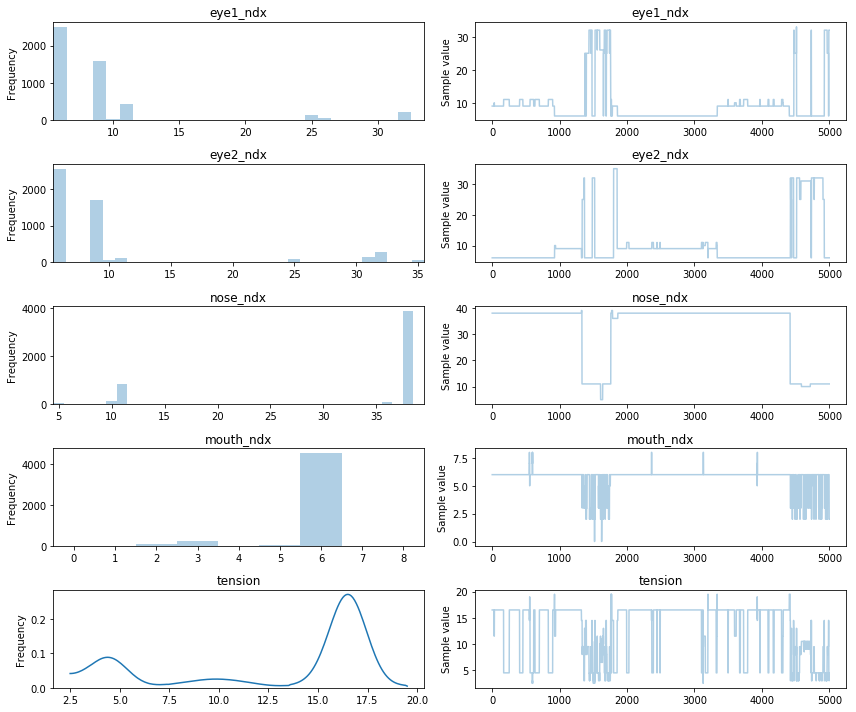

In [80]:
with face_detector:
    tr = pm.sample(draws=5000, tune=1000)
    if use_potentials:
        _ = pm.traceplot(tr, [eye1_ndx, eye2_ndx, nose_ndx, mouth_ndx, tension])
    else:
        _ = pm.traceplot(tr, [eye1_ndx, eye2_ndx, nose_ndx, mouth_ndx])        

Let us examine a few examples from the MCMC trace.

- If the potentials are not switched on, you should be able to see assignments where both eyes are actually coincident.
- In the non-face example this will be very clear as it only actually has one eye.

In [81]:
tr[1], tr[2], tr[3], tr[4], tr[5], tr[6], tr[7], tr[8]

({'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5},
 {'eye1_ndx': 9,
  'eye2_ndx': 6,
  'mouth_ndx': 6,
  'nose_ndx': 38,
  'tension': 16.5})

In [69]:
import math

def compute_tension(vals):
    eye1_ndx, eye2_ndx, nose_ndx, mouth_ndx = vals['eye1_ndx'], vals['eye2_ndx'], vals['nose_ndx'], vals['mouth_ndx']
    eye1_x, eye1_y = eye1_ndx%6, eye1_ndx//6
    eye2_x, eye2_y = eye2_ndx%6, eye2_ndx//6
    nose_x, nose_y = nose_ndx%6, nose_ndx//7
    mouth_x, mouth_y = 0, mouth_ndx
    
    # compute "configuration tension" 
    a = 0.5 * math.fabs((eye2_x-eye1_x)**2 + (eye1_y-eye2_y)**2 - 25)
    b = 0.5 * math.fabs((nose_x-eye1_x)**2 + (nose_y-eye1_y)**2 - 25)
    c = 0.5 * math.fabs((nose_x-eye2_x)**2 + (nose_y-eye2_y)**2 - 25)
    d = 0.5 * (mouth_y-nose_y-3)**2
    
    return a+b+c+d

# example from face 1
print('face 1 tension = %d' % compute_tension({'eye1_ndx': 0, 'eye2_ndx': 5, 'mouth_ndx': 7, 'nose_ndx': 33}))
# example from face 2
print('face 2 tension = %d' % compute_tension({'eye1_ndx': 0, 'eye2_ndx': 11, 'mouth_ndx': 7, 'nose_ndx': 32}))
# example from non-face
print('non-face tension = %d' % compute_tension({'eye1_ndx': 5, 'eye2_ndx': 12, 'mouth_ndx': 5, 'nose_ndx': 34}))


face 1 tension = 2
face 2 tension = 6
non-face tension = 10


## Exercise 2

In this exercise, we will start with an identified model (very simplified) of tagging a sequence of two tokens with its likely form, which can be one of 
`[Surname, GivenName, FirstInitial, LastInitial, Empty]`.

Note that the structure of this exercise is much more complex than exercises we have done before.

### Problem statement

The model receives an input of one or two words or initials and the result should be a set of tags that the model assigns to the words. Example:

- `['John', 'Smith'] --> ['GivenName', 'Surname']`
- `['Sculley', 'Dana'] --> ['Surname', 'GivenName']`
- `['J.', 'Smith'] --> ['FirstInitial', 'Surname']`
- `['Smith', 'J.'] --> ['Surname', 'FirstInitial']`
- `['Smith'] --> ['Surname', 'Empty']`

In our toy version of the problem we are only going to use three features for each token:
- number of characters, int >= 0
- presence of non-alphanumeric characters, 0/1
- list of known words for which we actually have probabilities of them being surnames vs. given names. Of course we frequently do not have a name on our list, so this data can be unobserved.

We first build part of our "knowledge base" and setup a preprocessing function and then introduce the structure of the model.

In [26]:
import theano
import theano.tensor as tt
import pymc3 as pm

In [27]:
# We map the tags into integers for use with PyMC3
token_tags = {'Surname' : 0,
              'GivenName' : 1,
              'FirstInitial' : 2,
              'LastInitial' : 3,
              'Empty' : 4}

We build a probability table that represents the probabilities of the form
`p(name='Gacs'|tag='surname')` under the assumption that the name token is observed, which means it is on our (very short list).

In [28]:
# List of "known names", mapped to integers 0..3
name_mapping = dict(zip(['gacs', 'john', 'smith', 'mark'], range(6)))

In [29]:
# function that maps a labeled example to features.
#
def encode_sample(name_toks):
    fs = []
    for i,(k,v) in enumerate(name_toks):
        fs.append({
            'tag': token_tags[k],
            'length': len(v),
            'has_nonalpha' : 1 if any([not ch.isalnum() for ch in v]) else 0,
            'known_name' : -1 if type(v) != str else name_mapping.get(v.lower(), -1)})

    # add an 'empty' tag if only one token is given
    if len(name_toks) < 2:
        fs.append({'tag' : 4,
                   'length' : 0,
                   'has_nonalpha' : 0,
                   'known_name' : -1})
    return fs


# example
encode_sample([('FirstInitial','J.'), ('Surname', 'Smith')])

[{'has_nonalpha': 1, 'known_name': -1, 'length': 2, 'tag': 2},
 {'has_nonalpha': 0, 'known_name': 2, 'length': 5, 'tag': 0}]

### Model structure

The model (without factor potentials) is structured as shown on the image below

![Without potential](images/tag_model_no_potential.png)

So the posterior probability distribution can be written as

$$f(\text{tag1},\text{tag2} \mid w_1, l_1, a_1, w_2, l_2, a_2) \;\;\; \propto \;\;\; f(w_1 \mid \text{tag1}) \;\;\; f(a_1 \mid \text{tag1}) \;\;\;  f(l_1 \mid \text{tag1}) \;\;\; f(w_2 \mid \text{tag2}) \;\;\; f(a_2 \mid \text{tag2}) \;\;\; f(l_2 \mid \text{tag2}) \;\;\; f(\text{tag1}) \;\;\; f(\text{tag2})$$

We further specify that:
- the `length` of a word has a Poisson distribution with a rate parameter conditional on the tag. The rate parameters are stored as `length_poisson_rate`, an array indexed by tag
- the probability of observing non-alpha numeric characters in a token is Bernoulli with probability $p$ again conditional on the tag, stored as an array `nonalpha_bernoulli_p`.  Non-alphanumeric characters (primarily dot) are expected only in initials and are unexpected in full names.
- if a name is known to us (exists in our shortlist), the probability that we observe it is given by the array `name_prob`.  Thus assuming the tag is GivenName, then observing John is not surprising whereas observing the token Gacs is quite surprising (and thus is assigned low probability).

Note that we assume that this model has already been fitted to some data (some of the values are indeed fitted to data, others are guessed) and we already have the parameters at hand. Those parameters are fitted below.  Please examine the model as written below and study the prior probabilities - check whether they are as you would expect.

### Testing the model
In the cell below are prepared some examples which can be passed to the model.  Uncommenting one sample will execute the model on it.

1. Please carefully examine the outputs and determine if it corresponds to the actual tags or not.
2. In some cases, the model makes an incorrect decision, do you see why when you examine the parameters of the model?
3. How could we fix this?

In [30]:
#data = encode_sample([('Surname', 'Gacs')])
#data = encode_sample([('GivenName', 'John')])
#data = encode_sample([('Surname', 'Gacs'),('GivenName', 'Peter')])
#data = encode_sample([('LastInitial', 'L.'), ('GivenName', 'John')])
data = encode_sample([('Surname', 'Smith'), ('FirstInitial', 'J.')])
data

[{'has_nonalpha': 0, 'known_name': 2, 'length': 5, 'tag': 0},
 {'has_nonalpha': 1, 'known_name': -1, 'length': 2, 'tag': 2}]

Assigned CategoricalGibbsMetropolis to tag1
Assigned CategoricalGibbsMetropolis to tag2
100%|██████████| 2500/2500 [00:00<00:00, 3605.50it/s]


Ground truth tags: tag1=0 tag2=2


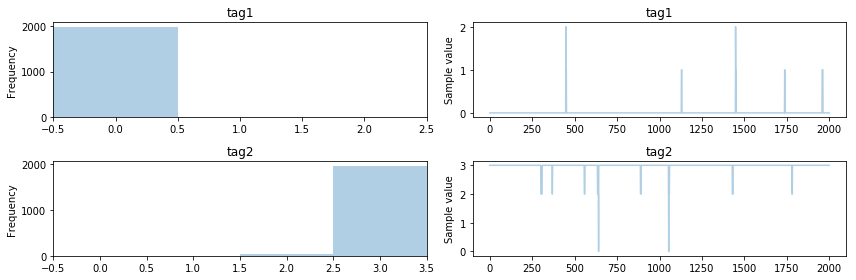

In [31]:
with pm.Model() as name_model:
    
    # priors for specific tokens appearing in slot 1 and slot 2
    tag1 = pm.Categorical('tag1', np.array([0.28, 0.696, 0.02, 0.001, 0.001]))
    tag2 = pm.Categorical('tag2', np.array([0.31, 0.058, 0.002, 0.13, 0.5]))
                        
    # distribution of number of chars
    length_poisson_rate = theano.shared(np.array([6., 6., 1., 1., 0.000001]))
    # distribution of non_alphachars
    nonalpha_bernoulli_p = theano.shared(np.array([0.001, 0.001, 0.8, 0.8, 0.001]))
    # name probabilities for observed names given known tags (see list name_mapping a few cells above)
    # p[1,2] is p(name='Smith'|tag='GivenName')
    name_prob = np.vstack([[0.999, 0.001, 0.999, 0.9, 0.0], #surname
                           [0.001, 0.999, 0.001, 0.1, 0.0], #givenname
                           [0.001, 0.001, 0.001, 0.001, 0.0], #firstinitial
                           [0.001, 0.001, 0.001, 0.001, 0.0], #lastinitial
                           [0.001, 0.001, 0.001, 0.001, 0.001]]) #empty
    known_name_categorical_p = theano.shared(np.array(name_prob))

    # make sure each row adds to one
    name_prob /= np.sum(name_prob, axis=1)[:, np.newaxis]
    name_prob

    len1 = pm.Poisson('len1', length_poisson_rate[tag1], observed = data[0]['length'])
    non_alpha1 = pm.Bernoulli('non_alpha1', nonalpha_bernoulli_p[tag1], observed = data[0]['has_nonalpha'])
    if data[0]['known_name'] >= 0:
        w1 = pm.Categorical('known_word1', known_name_categorical_p[tag1,:], observed = data[0]['known_name'])
        
    len2 = pm.Poisson('len2', length_poisson_rate[tag2], observed = data[1]['length'])
    non_alpha2 = pm.Bernoulli('non_alpha2', nonalpha_bernoulli_p[tag2], observed = data[1]['has_nonalpha'])
    if data[1]['known_name'] >= 0:
        w2 = pm.Categorical('known_word2', known_name_categorical_p[tag2,:], observed = data[1]['known_name'])
    
    tr = pm.sample(draws=2000, tune=500)
    
    pm.traceplot(tr)

# and print the actual tags
# reminder: {'Surname' : 0, 'GivenName' : 1,'FirstInitial' : 2, 'LastInitial' : 3, 'Empty' : 4}
print('Ground truth tags: tag1=%d tag2=%d' % (data[0]['tag'], data[1]['tag']))

### Factor potential

We now add a factor potential to the model which is multiplied with the rest of the model, so the full distribution is now:

$$f(\text{tag1},\text{tag2} \mid w_1, l_1, a_1, w_2, l_2, a_2) \;\;\; \propto \;\;\; f(w_1 \mid \text{tag1}) \;\;\; f(a_1 \mid \text{tag1}) \;\;\;  f(l_1 \mid \text{tag1}) \;\;\; f(w_2 \mid \text{tag2}) \;\;\; f(a_2 \mid \text{tag2}) \;\;\; f(l_2 \mid \text{tag2}) \;\;\; f(\text{tag1}) \;\;\; f(\text{tag2}) \;\;\; \mathbf{\Psi(\text{tag1},\text{tag2})}.$$

The new structure of the model is now as shown in the diagram.  The factor potential connects the two tag nodes and introduces a relationship between them that is encoded in the model as specified in the next cells.

![Model with factor potential](images/tag_model_with_potential.png)

Please analyse and try to understand what is the effect of the factor potential by running the examples.

Run the same examples through this model as well and compare the output to the model above.  What is the difference and why is the difference there?

In [32]:
# what data is going into the model? To change this, use the cell above the first model.
data

[{'has_nonalpha': 0, 'known_name': 2, 'length': 5, 'tag': 0},
 {'has_nonalpha': 1, 'known_name': -1, 'length': 2, 'tag': 2}]

Assigned CategoricalGibbsMetropolis to tag1
Assigned CategoricalGibbsMetropolis to tag2
100%|██████████| 2500/2500 [00:00<00:00, 3681.06it/s]


Ground truth tags: tag1=0 tag2=2


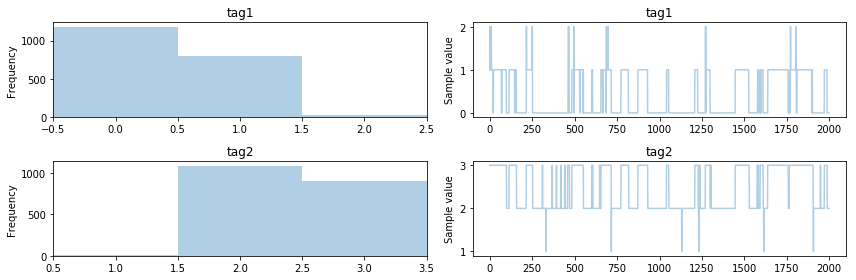

In [33]:
with pm.Model() as name_model:
    
    # priors for specific tokens appearing in slot 1 and slot 2
    tag1 = pm.Categorical('tag1', np.array([0.28, 0.696, 0.02, 0.001, 0.001]))
    tag2 = pm.Categorical('tag2', np.array([0.31, 0.058, 0.002, 0.13, 0.5]))
                        
    # distribution of number of chars
    length_poisson_rate = theano.shared(np.array([6., 6., 1., 1., 0.000001]))
    # distribution of non_alphachars
    nonalpha_bernoulli_p = theano.shared(np.array([0.001, 0.001, 0.8, 0.8, 0.001]))
    # name probabilities for observed names given known tags (see list name_mapping a few cells above)
    # p[1,2] is p(name='Smith'|tag='GivenName')
    name_prob = np.vstack([[0.999, 0.001, 0.999, 0.9, 0.0], #surname
                           [0.001, 0.999, 0.001, 0.1, 0.0], #givenname
                           [0.001, 0.001, 0.001, 0.001, 0.0], #firstinitial
                           [0.001, 0.001, 0.001, 0.001, 0.0], #lastinitial
                           [0.001, 0.001, 0.001, 0.001, 0.001]]) #empty
    known_name_categorical_p = theano.shared(np.array(name_prob))

    # make sure each row adds to one
    name_prob /= np.sum(name_prob, axis=1)[:, np.newaxis]
    name_prob

    len1 = pm.Poisson('len1', length_poisson_rate[tag1], observed = data[0]['length'])
    non_alpha1 = pm.Bernoulli('non_alpha1', nonalpha_bernoulli_p[tag1], observed = data[0]['has_nonalpha'])
    if data[0]['known_name'] >= 0:
        w1 = pm.Categorical('known_word1', known_name_categorical_p[tag1,:], observed = data[0]['known_name'])
        
    len2 = pm.Poisson('len2', length_poisson_rate[tag2], observed = data[1]['length'])
    non_alpha2 = pm.Bernoulli('non_alpha2', nonalpha_bernoulli_p[tag2], observed = data[1]['has_nonalpha'])
    if data[1]['known_name'] >= 0:
        w2 = pm.Categorical('known_word2', known_name_categorical_p[tag2,:], observed = data[1]['known_name'])
    
    # Potential term that encodes interactions between tokens
    # Reminder: 'Surname' : 0, 'GivenName' : 1, 'FirstInitial' : 2, 'LastInitial' : 3, 'Empty' : 4
    potential_p = theano.shared(np.log(np.vstack(
        [[0.001, 0.8, 0.8, 0.001, 0.8],          #surname
         [0.8, 0.001, 0.001, 0.8, 0.8],          #givenname
         [0.8, 0.001, 0.001, 0.8, 0.8],          #firstinitial
         [0.001, 0.8, 0.001, 0.001, 0.8],        #lastinitial
         [0.001, 0.001, 0.001, 0.001, 0.001]]))) #empty
    pm.Potential('potential_p', potential_p[tag1, tag2])
    
    tr = pm.sample(draws=2000, tune=500)
    
    pm.traceplot(tr)

# and print the actual tags
# reminder: {'Surname' : 0, 'GivenName' : 1,'FirstInitial' : 2, 'LastInitial' : 3, 'Empty' : 4}
print('Ground truth tags: tag1=%d tag2=%d' % (data[0]['tag'], data[1]['tag']))        

## Conclusions

We have examined the construction of models and the role of different tyes of variable.

One of the building blocks is the factor potential. Factor potentials can establish a structure in the model output and thus eliminate predictions which are not compatible. Factor potentials conceptually introduce a symmetric term (corresponding to an undirected link in the model graph) into the posterior while hierarchical Bayesian terms correspond do directed relationships. We have studied this in two models in detail.

## Custom operations - extra material

For more complex distributions, one can create a subclass of `Continuous` or `Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified, for example the [Normal distribution](https://github.com/pymc-devs/pymc3/blob/999661c092310b1f247f14037f795a852425e9c9/pymc3/distributions/continuous.py#L227).

As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with a sub-function using the `as_op` decorator, though this is not strictly necessary.

In [34]:
from pymc3.distributions import Continuous
import theano.tensor as tt
from theano import as_op

class Beta(Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)